In [3]:
!pip install imutils
!pip install gdown
!pip install scipy

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=96d72c3bb7ee3f64df4a06ff71e7b43a40c78bad5494aa16961a323ab12dae71
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [13]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torchvision import datasets
from imutils import paths
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torchvision
from torchvision import datasets, transforms
from scipy.io import loadmat
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from pprint import pprint
from sklearn.neighbors import KNeighborsClassifier
import plotly.graph_objects as go
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [5]:
data_path = './'

dataset = datasets.Caltech101(
    root=data_path,
    download=True,
)

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=d77ff48a-912a-4033-9813-5872332ce328
To: /kaggle/working/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:02<00:00, 54.9MB/s] 


Extracting ./caltech101/101_ObjectCategories.tar.gz to ./caltech101


Downloading...
From: https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
To: /kaggle/working/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 45.4MB/s]


Extracting ./caltech101/Annotations.tar to ./caltech101


In [6]:
mat_file_path = "/kaggle/working/caltech101/Annotations/bass/annotation_0005.mat"
data = loadmat(mat_file_path)

pprint(data)

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Wed Dec 15'
               b' 15:08:56 2004',
 '__version__': '1.0',
 'box_coord': array([[ 42, 150,  12, 286]], dtype=uint16),
 'obj_contour': array([[  8.63916877,  24.22481108,  50.20088161,  82.41120907,
         91.41624685,  94.87972292, 120.16309824, 137.8268262 ,
        161.37846348, 176.61775819, 191.8570529 , 190.12531486,
        173.84697733, 194.28148615, 212.98425693, 262.85831234,
        270.4779597 , 272.55604534, 267.36083123, 266.66813602,
        272.55604534, 269.09256927, 253.16057935, 226.14546599,
        213.33060453, 191.8570529 , 174.53967254, 186.66183879,
        189.08627204, 182.1593199 , 173.50062972, 152.02707809,
         99.72858942, 108.7336272 , 107.34823678,  95.91876574,
         79.98677582,  51.23992443,  37.73236776,   2.40491184,
          3.79030227,  21.10768262,   7.25377834,   8.63916877,
          8.63916877],
       [ 52.05604534,  45.47544081,  32.66

In [7]:
image_paths = list(paths.list_images('./caltech101'))

data = []
labels = []
for img_path in tqdm(image_paths):
    label = img_path.split(os.path.sep)[-2]
    if label == "BACKGROUND_Google":
        continue
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    size = img.shape[0]*img.shape[1]
    hist = hist/size

    data.append(hist)
    labels.append(label)
    
data = np.array(data)
labels = np.array(labels)


100%|██████████| 9144/9144 [00:07<00:00, 1240.03it/s]


In [8]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
print(f"Total Number of Classes: {len(lb.classes_)}")

Total Number of Classes: 101


In [9]:
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=1 - train_ratio, stratify= labels)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify= y_test) 

x_train = x_train.reshape(len(x_train), 256)
x_val = x_val.reshape(len(x_val), 256)
x_test = x_test.reshape(len(x_test), 256)
print(len(x_train))
print(len(x_val))
print(len(x_test))


5206
1735
1736


# **Yêu cầu 1**
## Áp dụng thuật toán KNN, tính Accuracy trên tập val và test với các giá trị k lần lượt:1,2,3,4,5


In [10]:
best_score = 0
best_k = 0
results = []

for i in range(1, 6):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)

    val_predictions = knn.predict(x_val)
    val_score = accuracy_score(y_val, val_predictions)
    
    test_predictions = knn.predict(x_test)
    test_score = accuracy_score(y_test, test_predictions)
    
    results.append({'k': i, 'Validation Accuracy': val_score, 'Test Accuracy': test_score})
    
    if val_score > best_score:
        best_score = val_score
        best_k = i
    
    print(f'KNN with k={i}: Validation Accuracy = {val_score:.4f}, Test Accuracy = {test_score:.4f}')

print(f"Best Validation Score = {best_score:.4f} with k = {best_k}")

results_df = pd.DataFrame(results)

table = go.Figure(data=[go.Table(
    header=dict(values=["k", "Validation Accuracy", "Test Accuracy"],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[results_df.k, results_df['Validation Accuracy'], results_df['Test Accuracy']],
               fill_color='lavender',
               align='left'))
])

table.update_layout(
    title='KNN Accuracy for Validation and Test Sets',
    height=350 
)

table.data[0].columnwidth = [50, 150, 150]  

table.show()


KNN with k=1: Validation Accuracy = 0.2334, Test Accuracy = 0.2333
KNN with k=2: Validation Accuracy = 0.2329, Test Accuracy = 0.2321
KNN with k=3: Validation Accuracy = 0.2450, Test Accuracy = 0.2483
KNN with k=4: Validation Accuracy = 0.2473, Test Accuracy = 0.2465
KNN with k=5: Validation Accuracy = 0.2513, Test Accuracy = 0.2454
Best Validation Score = 0.2513 with k = 5


# **Yêu cầu 2**
## Áp dụng thuật toán SVC (với tham số C=1)
* Tính Accuracy cho tập test
* Tính Precision của từng lớp (class)


In [11]:
svc_model = SVC(C=1)
svc_model.fit(x_train, y_train)

y_test_pred = svc_model.predict(x_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

report = classification_report(y_test, y_test_pred, target_names=[str(i) for i in np.unique(labels)], zero_division=0)
print("Classification Report:")
print(report)

Test Accuracy: 0.2632
Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.43      0.17        87
           1       0.15      0.76      0.25        87
           2       0.29      0.68      0.41        40
           3       0.46      0.81      0.59       160
           4       0.23      0.27      0.25        11
           5       0.51      0.85      0.64       160
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00         9
          11       0.20      0.17      0.18         6
          12       0.00      0.00      0.00        26
          13       0.13      0.10      0.11        20
          14       0.00      0.00      0.00         8
          15       0.00      0.00      0.00        17
          16       0.00      0.00   

# **Yêu cầu 3**
## Áp dụng thuật toán SVC (với tham số C=1)
* Sử dụng chiến lược 1 vs 1
* Tính Accuracy cho tập test
* Tính số support vector
* Tính và hiển thị ma trận Confusion


Test Accuracy (One vs One): 0.2811
Total number of support vectors: 290359


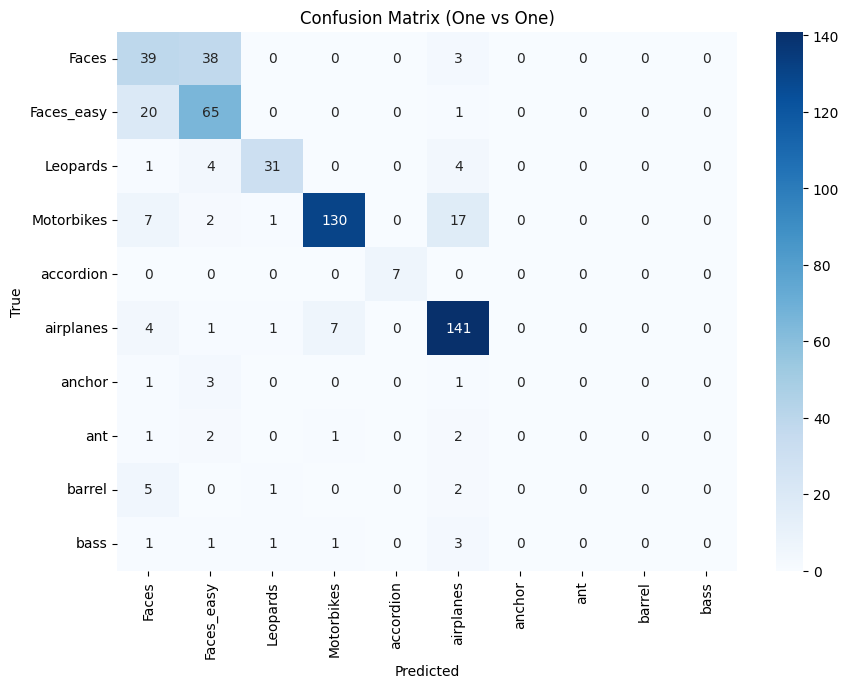

In [19]:
svc = SVC(C=1)
ovo_model = OneVsOneClassifier(svc)
ovo_model.fit(x_train, y_train)

y_test_pred = ovo_model.predict(x_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy (One vs One): {test_accuracy:.4f}")
all_support_vectors = []
for estimator in ovo_model.estimators_:
    all_support_vectors.extend(estimator.support_vectors_)
print(f"Total number of support vectors: {len(all_support_vectors)}")

cm = confusion_matrix(y_test, y_test_pred)

cm_subset = cm[:10, :10]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_[:10], yticklabels=lb.classes_[:10])
plt.title('Confusion Matrix (One vs One)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# **Yêu cầu 4**
## Áp dụng thuật toán SVC (với tham số C=1)
## Sử dụng chiến lược 1 vs rest:
* Tính Accuracy cho tập test
* Tính số support vector
* Tính và hiển thị ma trận Confusion



Test Accuracy (1 vs Rest): 0.2569
Total number of support vectors: 35875


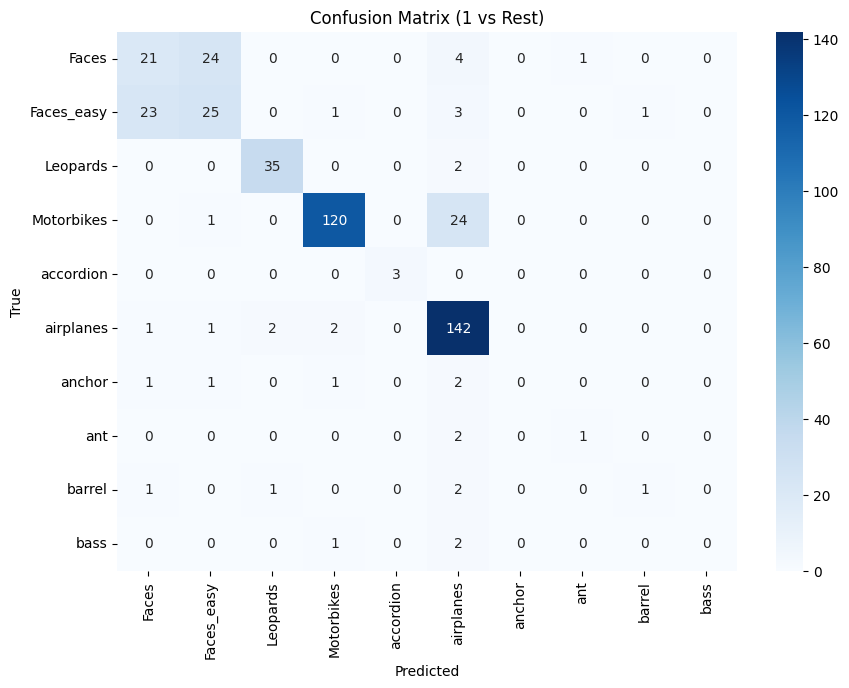

In [20]:
svc_model_rest = SVC(C=1) 
ovr_model_rest = OneVsRestClassifier(svc_model_rest)

ovr_model_rest.fit(x_train, y_train)

y_test_pred_rest = ovr_model_rest.predict(x_test)

test_accuracy_rest = accuracy_score(y_test, y_test_pred_rest)
print(f"Test Accuracy (1 vs Rest): {test_accuracy_rest:.4f}")
all_support_vectors = []
for estimator in ovr_model_rest.estimators_:
        all_support_vectors.extend(estimator.support_vectors_)

print(f"Total number of support vectors: {len(all_support_vectors)}")

cm_rest = confusion_matrix(y_test, y_test_pred_rest)

cm_rest_subset = cm_rest[:10, :10]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_rest_subset, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_[:10], yticklabels=lb.classes_[:10])
plt.title('Confusion Matrix (1 vs Rest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# **Yêu cầu 5**
## Áp dụng thuật toán SVC 
## Xác định giá trị tham số C để đạt được Accuracy tốt nhất.


In [14]:
param_grid = {'C': np.arange(0.1, 101, 5)} 

svc_model = SVC(kernel='rbf', decision_function_shape='ovr')
grid_search = GridSearchCV(svc_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_C', 'mean_test_score', 'std_test_score']])

   param_C  mean_test_score  std_test_score
0      0.1         0.213021        0.007257
1      5.1         0.274682        0.007524
2     10.1         0.277563        0.009733
3     15.1         0.281214        0.008782
4     20.1         0.281021        0.007820
5     25.1         0.282366        0.007356
6     30.1         0.284095        0.007517
7     35.1         0.282174        0.008746
8     40.1         0.283134        0.008426
9     45.1         0.282749        0.009737
10    50.1         0.281789        0.011410
11    55.1         0.282749        0.012329
12    60.1         0.281404        0.010595
13    65.1         0.282173        0.008251
14    70.1         0.282173        0.009388
15    75.1         0.281789        0.010379
16    80.1         0.281213        0.008316
17    85.1         0.280828        0.008267
18    90.1         0.279868        0.008515
19    95.1         0.280444        0.008665
20   100.1         0.279292        0.008091


In [18]:
param_grid = {'C': np.arange(25, 36, 1)} 

svc_model = SVC(kernel='rbf', decision_function_shape='ovr')
grid_search = GridSearchCV(svc_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_C', 'mean_test_score', 'std_test_score']])

   param_C  mean_test_score  std_test_score
0       25         0.282750        0.007112
1       26         0.283326        0.007288
2       27         0.283134        0.008233
3       28         0.284287        0.007825
4       29         0.285440        0.007238
5       30         0.284095        0.007517
6       31         0.283135        0.007069
7       32         0.282558        0.007530
8       33         0.282174        0.007436
9       34         0.281406        0.008995
10      35         0.281790        0.008626


In [19]:
print(f"Best C value: {grid_search.best_params_['C']}")
print(f"Best Accuracy: {grid_search.best_score_:.4f}")

Best C value: 29
Best Accuracy: 0.2854
